# Sparsity enforcing regularisation

This notebook is an extension to the notebook `SRT_inversion.ipynb` and uses the same data and the same setup to stup the forward problem. In this notebook, we consider two regularisation strategies that allow us to reconstruct the piecewise homogeneous nature of the phantom. First, we will consider total-variation (TV) regularisation in the pixel domain before moving on to a sparsity enforcing transformations of the model vector that allow us to compress information to a small number of transformed model coefficients.
In this notebook, we use the `PyLops` toolbox that allows us to generate a number of different linear operators that can be used in the form of matrices to solve our tomographic inverse problem.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from tqdm import trange
import scipy
import pylops
from pylops import LinearOperator
import itertools
import straight_ray_tomo
import xarray as xr
from grid import *

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 25})
plt.rcParams["xtick.major.pad"] = "15"
plt.rcParams["ytick.major.pad"] = "15"

## Utility functions

In [2]:
def plot_model(m, g, title=None, caxis=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    if not title == None:
        ax.set_title(title)

    plt.imshow(
        np.reshape(m, [g.coords["x"].shape[0], g.coords["y"].shape[0]]).T,
        extent=[
            g.coords["x"][0],
            g.coords["x"][0] + g.coords["x"].shape[0] * g["spacing"],
            g.coords["y"][0],
            g.coords["y"][0] + g.coords["y"].shape[0] * g["spacing"],
        ],
        cmap="gray",
    )
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if caxis is not None:
        plt.clim(caxis)
    plt.colorbar(label="s [s/m]")

In [3]:
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
gg = lambda x, pos: "${}$".format(f._formatSciNotation("%1.10e" % x))
fmt = mticker.FuncFormatter(gg)


def plot_Lcurve_sparseTV(x_vals, y_vals, reg_param, title, a, TV=False):
    colors = itertools.cycle(["gold", "orange", "red", "blueviolet"])
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)
    for i in range(len(x_vals)):
        if i in a:
            if TV:
                ax.plot(
                    np.log(x_vals[i] / np.max(x_vals)),
                    y_vals[i],
                    "o",
                    label="$\\alpha$ = {}".format(fmt(np.round(reg_param[i], 6))),
                    color=next(colors),
                    markersize=10,
                )
                ax.plot(
                    np.log(x_vals[i] / np.max(x_vals)),
                    y_vals[i],
                    "ko",
                    fillstyle="none",
                    markersize=10,
                )
                ax.legend()
            else:
                ax.plot(
                    x_vals[i],
                    y_vals[i],
                    "o",
                    label="$\\alpha$ = {}".format(fmt(np.round(reg_param[i], 6))),
                    color=next(colors),
                    markersize=10,
                )
                ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
                ax.legend()

        else:
            if TV:
                ax.plot(
                    np.log(x_vals[i] / np.max(x_vals)),
                    y_vals[i],
                    "ko",
                    fillstyle="none",
                    markersize=10,
                )
                ax.set_xlabel(
                    "residual norm ||$\\mathbf{G}\\mathbf{m}_\\alpha-\\mathbf{d}$||$_2$",
                    labelpad=15,
                )
                ax.set_ylabel(
                    "solution norm ||$\\nabla\\mathbf{m}_\\alpha$||$_1$", labelpad=15
                )
            else:
                ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
                ax.set_xlabel(
                    "residual norm ||$\\mathbf{G}\\mathbf{m}_\\alpha-\\mathbf{d}$||$_2$",
                    labelpad=15,
                )
                ax.set_ylabel(
                    "solution norm ||$\\mathbf{P}\\mathbf{m}_\\alpha$||$_1$",
                    labelpad=15,
                )
        ax.set_title(title, pad=20)
    ax.grid()
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

## 1. Set up the geometry
### 1.1 Sources and receivers

In [4]:
nrec = 256  # number of receivers
reccoo = np.load("data/reccoo.npy")

### sources and receivers coincide
srccoo = np.copy(reccoo)
sources, receivers = straight_ray_tomo.get_all_to_all_locations(srccoo, reccoo)

### 1.2 Computational domain and rectilinear grid

Here, we set up the rectilinear grid.

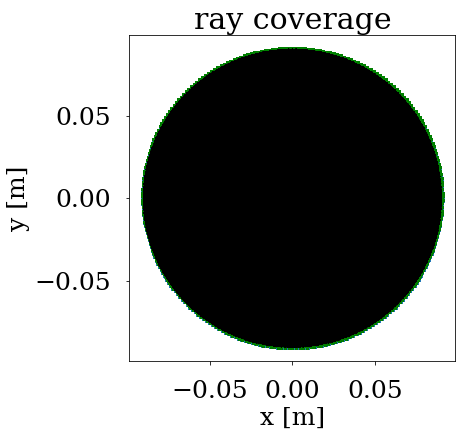

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'ray coverage'}, xlabel='x [m]', ylabel='y [m]'>)

In [5]:
spacing = 0.0008
min_x = min(np.min(sources[:, 0]), np.min(receivers[:, 0]))
min_y = min(np.min(sources[:, 1]), np.min(receivers[:, 1]))
max_x = max(np.max(sources[:, 0]), np.max(receivers[:, 0]))
max_y = max(np.max(sources[:, 1]), np.max(receivers[:, 1]))

npoints = np.array(
    [int(np.ceil((max_x - min_x) / spacing)), int(np.ceil((max_y - min_y) / spacing))]
)

g = xr.Dataset(
    coords={
        "x": np.linspace(min_x, max_x, npoints[0], endpoint=True),
        "y": np.linspace(min_y, max_x, npoints[1], endpoint=True),
        "spacing": spacing,
    },
)

### plot the rays that connect sources and receivers
straight_ray_tomo.plot_rays(sources, receivers, g)

### 1.3 Compute straight-ray-tracing forward operator

Next, we set up the straight-ray-tracing matrix $\mathbf{G}$ that we later need in the inversions. $\mathbf{G}$ connects a slowness model $\mathbf{m}$ to our observed time-of-flight shifts $\mathbf{d}$. The number of rows of $\mathbf{G}$ is equal to the number of data points, thus to the number of rays that connect all source receiver pairs. The number of columns of $\mathbf{G}$ is equal to the unknowns in model space and thus to the number of pixels definde by the computational grid.

Matrix shape:             (65536, 50625)
Data points:              65536
Unknowns in model space:  50625
Non-zero entries:         11955460
Ratio of non-zeros:     0.3603 %


(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:title={'center':'spacing = 0.0008'}, xlabel='x [m]', ylabel='y [m]'>)

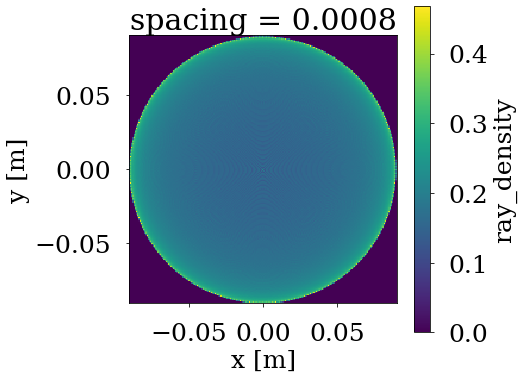

In [6]:
G = straight_ray_tomo.create_forward_operator(sources, receivers, g)
print("Matrix shape:            ", G.shape)
print("Data points:             ", G.shape[0])
print("Unknowns in model space: ", G.shape[1])
print("Non-zero entries:        ", G.count_nonzero())
print(
    "Ratio of non-zeros: {:10.4f} %".format(
        100 * G.count_nonzero() / (G.shape[0] * G.shape[1])
    )
)

straight_ray_tomo.plot_ray_density(G, g)

### 1.4 Define Pylops operators

In [7]:
class myOperator(LinearOperator):
    def __init__(self, G):
        self.G = G
        self.shape = self.G.shape
        self.dtype = np.dtype(dtype="float64")
        self.explicit = False

    def _matvec(self, x):
        return self.G @ x

    def _rmatvec(self, x):
        return self.G.T @ x

In [8]:
class mycomplexOperator(LinearOperator):
    def __init__(self, G):
        self.G = G
        self.shape = self.G.shape
        self.dtype = np.dtype(dtype="complex128")
        self.explicit = False

    def _matvec(self, x):
        return self.G @ x

    def _rmatvec(self, x):
        return self.G.T @ x

## 2. Inverse Problem setup
With the next lines, we will set up the linearised inverse problem that allows us to reconstruct the speed-of-sound map of the tissue mimicking phantom.

### 2.1 Initialize homogeneous background medium
As a prior in model space, we chose a homogeneous model with slowness values being equal to that of water (s=1/1500 s/m).

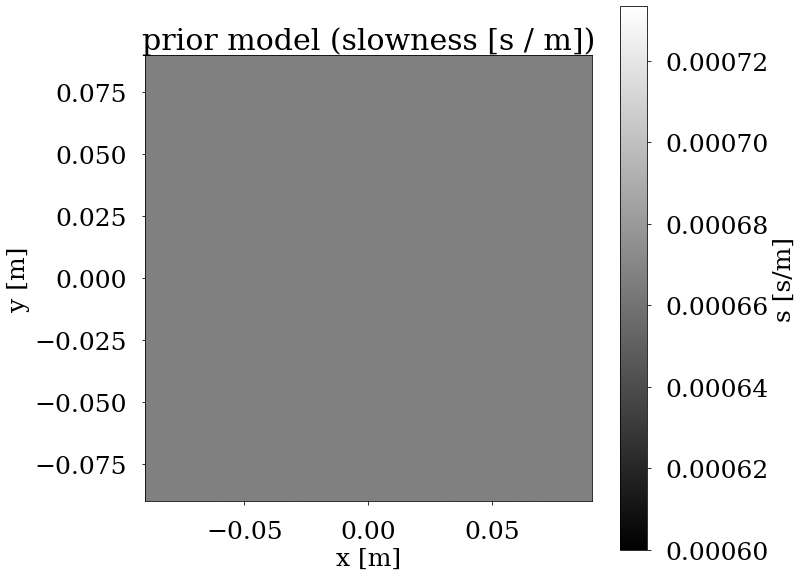

In [9]:
prior = 1500 * np.ones(npoints)
g["soundspeed"] = (["x", "y"], prior)
m_prior = (1 / np.array(g.data_vars["soundspeed"])).ravel()

plot_model(m_prior, g, "prior model (slowness [s / m])")

### 2.2 Load the observed data: correlation time-of-flight sifts

In [10]:
tof_shifts = np.load("data/tof_shifts.npy")
### check that we have corresponding sizes
print(tof_shifts.shape, G.shape)

(65536,) (65536, 50625)


## 3. Solve regularized least-squares Problem: **Total-Variation regularisation**
For total-variation, the regularisation term is defined as the $\ell_1$ norm of the spatial gradient of the model vector in pixels space
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\nabla\mathbf{m}||_1,$$
where $\mathbf{G}$ is the straight-ray-tacing forward matrix, $\mathbf{m}$ the model parametrized in slowness, $\mathbf{d}$ our observed time-of-flight shifts and $\alpha$ the regularisation damping. With this, we obtain a reconstruction the slowness structure of the tissue. The $\ell_1$ norm, which promotes jumps in the gradient characterizing sharp edges is especially efficient for the reconstruction of piecewise homogeneous models. The latter are of specific interest in medical ultrasound, since human tissue structures are often characterized to be locally homogeneous with discontinuities between different tissue types.

As in the notebook `SRT_inversion.ipynb`, we tune the amount of prior information that is injected into the problem via the regularisation term, we use an L-curve plot to visualize the contribution of the solution and the residual norm.

### 3.1 Tuning the regularisation weight: L-curve plots

In [11]:
def L_curve_TV(D, myOp, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        solution = pylops.optimization.sparsity.SplitBregman(
            myOp,
            D,
            d,
            niter_outer=100,
            niter_inner=5,
            mu=1.0,  # Data term damping
            epsRL1s=[reg_param[i], reg_param[i], reg_param[i]],
            tol=1e-8,
            tau=1.0,
            show=False,
            **dict(iter_lim=5, damp=0)
        )
        m_rec_wf = m_prior - solution[0]
        x_values[i] = np.linalg.norm(myOp._matvec(m_rec_wf) + d)
        y_values[i] = np.linalg.norm(
            D[0].dot(m_rec_wf + m_prior) + D[1].dot(m_rec_wf + m_prior)
        )
    return x_values, y_values

In [12]:
Nz, Nx = npoints
### Define first derivative
Dop = [
    pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=0, edge=False),
    pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=1, edge=False),
]
### Define forward operator with PyLops
myOp = myOperator(G)
### regularisation weight to test in L curve
### test the regularisation weight over a wide ofer a range of orders
reg_param = np.array(
    [
        1e-10,
        5e-10,
        1e-9,
        5e-9,
        1e-8,
        5e-8,
        1e-7,
        5e-7,
        1e-6,
        5e-6,
        1e-5,
        5e-5,
        1e-4,
        5e-4,
        1e-3,
        5e-3,
        1e-2,
        5e-2,
        1e-1,
        5e-1,
    ]
)
### for a zoom in on relevant regularisation weights (to reproduce figure 8a)
# reg_param = np.linspace(5e-6, 5e-4, 30)

In [13]:
### for CI testing
b = 1
### to reproduce figures
# b = reg_param.shape[0]
x_values_TV, y_values_TV = L_curve_TV(Dop, myOp, tof_shifts, reg_param[:b], m_prior)

100%|██████████| 1/1 [01:38<00:00, 98.99s/it]


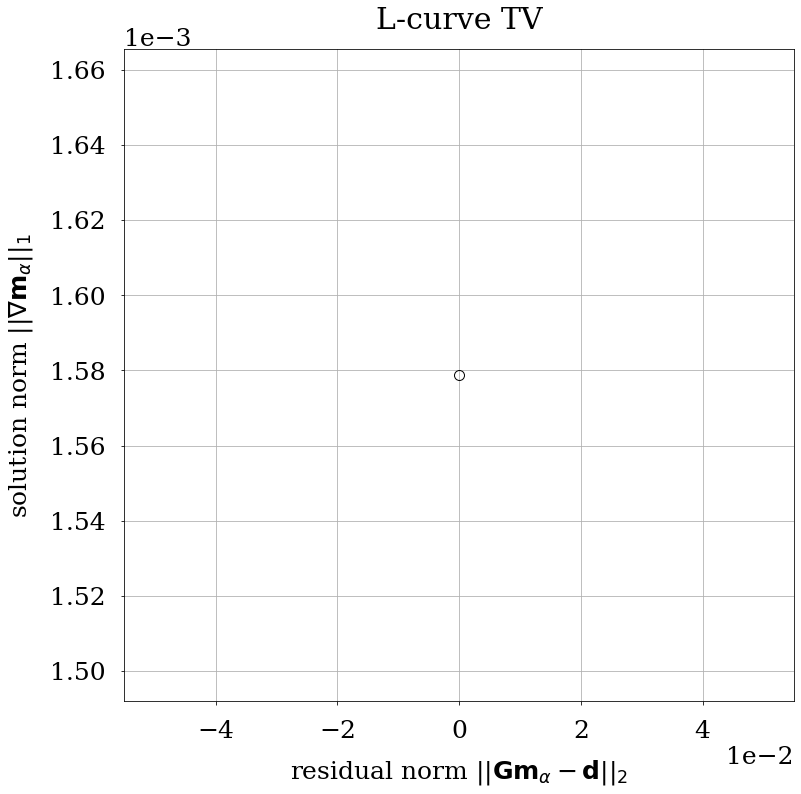

In [14]:
a = [2, 6]  # selected regularisation weigths are represented by colored dots
plot_Lcurve_sparseTV(x_values_TV, y_values_TV, reg_param, "L-curve TV", a, TV=True)
# plt.savefig("../usct-interferometry/Analytical_Random_Wavefield/Phantom_experiments/Simulations/02_Analyticalphantom_RingSrcArray/figures/L-curveTV.eps",bbox_inches="tight")

### 3.2 Invert for the phantom structure: **TV regularisation**
Finally, we are ready to invert for the speed-of-sound structure using the damping values we select from the L-curve plot.

In [26]:
### for CI testing
niter_outer = 10
### to reproduce figures
# niter_outer = 300

epsRL1s = np.array((reg_param[2]))
imtv = pylops.optimization.sparsity.SplitBregman(
    myOp,
    Dop,
    tof_shifts,
    niter_outer=niter_outer,
    niter_inner=5,
    mu=1.0,  # Data term damping
    epsRL1s=[epsRL1s, epsRL1s, epsRL1s],
    tol=1e-8,
    tau=1.0,
    show=True,
    **dict(iter_lim=5, damp=0.0)
)[0]

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 65536 rows and 50625 cols
niter_outer =  10     niter_inner =   5   tol = 1.00e-08
mu = 1.00e+00         epsL1 = [array(1.e-09), array(1.e-09), array(1.e-09)]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   0.00000e+00        4.636e-12        2.370e-01
     2  3.58687e-221        2.128e-12        2.657e-01
     3  4.58623e-209        1.758e-12        2.723e-01
     4  3.13277e-201        1.612e-12        2.757e-01
     5  7.92890e-196        1.524e-12        2.776e-01
     6  1.88517e-191        1.461e-12        2.793e-01
     7  4.26876e-188        1.412e-12        2.806e-01
     8  3.90366e-185        1.373e-12        2.820e-01
     9  9.39421e-183        1.340e-12        2.832e-01
    10  1.44270e-180        1.311e-12        2.845e-01

Iterations = 10        Total time (s) = 9.34
------

Text(0.5, 1.0, 'reconstructed velocity')

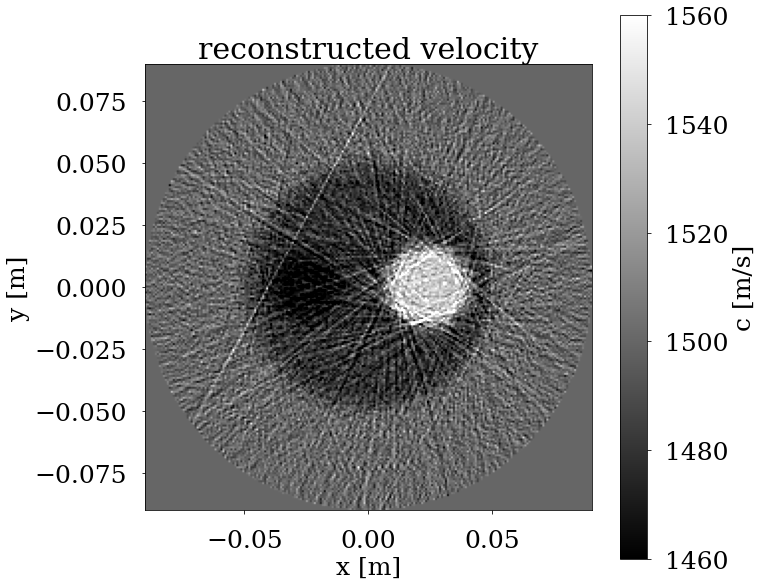

In [23]:
imtv_velocity = 1 / (m_prior - imtv)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(
    np.reshape(imtv_velocity, [g.x.shape[0], g.y.shape[0]]).T,
    extent=[
        g.x[0],
        g.x[0] + g.x.shape[0] * g.spacing,
        g.y[0],
        g.y[0] + g.y.shape[0] * g.spacing,
    ],
    cmap="gray",
    vmin=1460,
    vmax=1560,
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar(label="c [m/s]")
plt.title("reconstructed velocity")

## 4. Solve regularized least-squares Problem: **sparsity enforcing transform**

In this section, we exploit the sparsity of the model in the fourier domain. This allows us to efficiently select the coefficients that contain most structural information. We then use these coefficients as a penalty term together with the $\ell_1$-norm, such that
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\mathbf{P}\mathbf{m}||_1.$$
In the following, the  the `Pylops` operator `FFTop` is used, which provides the Fourier operator in 2D. As previously, we start by examining the L-curve plot in order to determine the regularization weight.

In [17]:
def L_curve_L1_sparse(P, myOp, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        solution = pylops.optimization.sparsity.SplitBregman(
            myOp,
            P,
            d,
            niter_outer=100,
            niter_inner=5,
            mu=1.0,  # Data term damping
            epsRL1s=[reg_param[i], reg_param[i], reg_param[i]],
            tol=1e-8,
            tau=1.0,
            show=False,
            **dict(iter_lim=5, damp=0)
        )
        m_rec_wf = m_prior - np.real(solution[0])
        x_values[i] = -np.linalg.norm(myOp._matvec(m_rec_wf) + d)
        y_values[i] = np.linalg.norm(P[0].dot(m_rec_wf - m_prior))
    return x_values, y_values

In [18]:
### for CI testing
b = 1
### to reproduce figures
# b = reg_param.shape[0]

### Define Fourier operator
FFTop = pylops.signalprocessing.FFT2D(dims=npoints)
### Bonus: try the wavelet operator instead of the Fourier operator
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=2)
### Define forward operator with PyLops --> This time we need a complex forward operator.
myOp = mycomplexOperator(G)

x_values_fft, y_values_fft = L_curve_L1_sparse(
    [FFTop], myOp, tof_shifts, reg_param[:b], m_prior
)

100%|██████████| 1/1 [11:43<00:00, 703.36s/it]


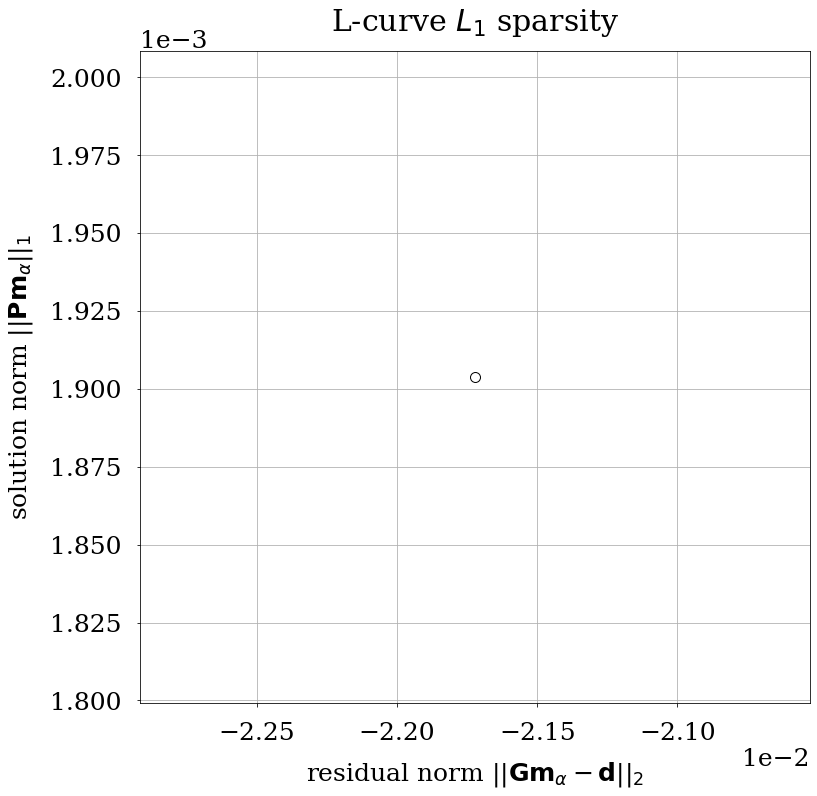

In [19]:
a = [2, 6]  # selected regularisation weigths are represented by colored dots
plot_Lcurve_sparseTV(x_values_fft, y_values_fft, reg_param, "L-curve $L_1$ sparsity", a)

### 4.2 Invert for the phantom structure: **sparsity enforcing transform**
Again, we make use of the above L-curve to select meaningful values for the regularisation parameter $\alpha$.

In [20]:
### for CI testing
niter_outer = 10
### to reproduce figures
# niter_outer = 300

epsRL1s = np.array((reg_param[2]))
imsparse = pylops.optimization.sparsity.SplitBregman(
    myOp,
    [FFTop],
    tof_shifts,
    niter_outer=niter_outer,
    niter_inner=5,
    mu=1.0,  # Data term damping
    epsRL1s=[epsRL1s, epsRL1s, epsRL1s],
    tol=1e-8,
    tau=1.0,
    show=True,
    **dict(iter_lim=5, damp=0)
)[0]

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 65536 rows and 50625 cols
niter_outer =  10     niter_inner =   5   tol = 1.00e-08
mu = 1.00e+00         epsL1 = [array(1.e-09), array(1.e-09), array(1.e-09)]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -7.17957e-15        4.634e-12        2.080e-01
     2  -2.06658e-14        2.127e-12        2.315e-01
     3  -2.81447e-14        1.758e-12        2.375e-01
     4  -3.40914e-14        1.612e-12        2.409e-01
     5  -4.05466e-14        1.523e-12        2.429e-01
     6  -4.86233e-14        1.461e-12        2.448e-01
     7  -5.64415e-14        1.412e-12        2.462e-01
     8  -6.47576e-14        1.373e-12        2.477e-01
     9  -7.23150e-14        1.340e-12        2.489e-01
    10  -8.13091e-14        1.311e-12        2.503e-01

Iterations = 10        Total time (s) = 72.60
-----

Text(0.5, 1.0, 'reconstructed velocity')

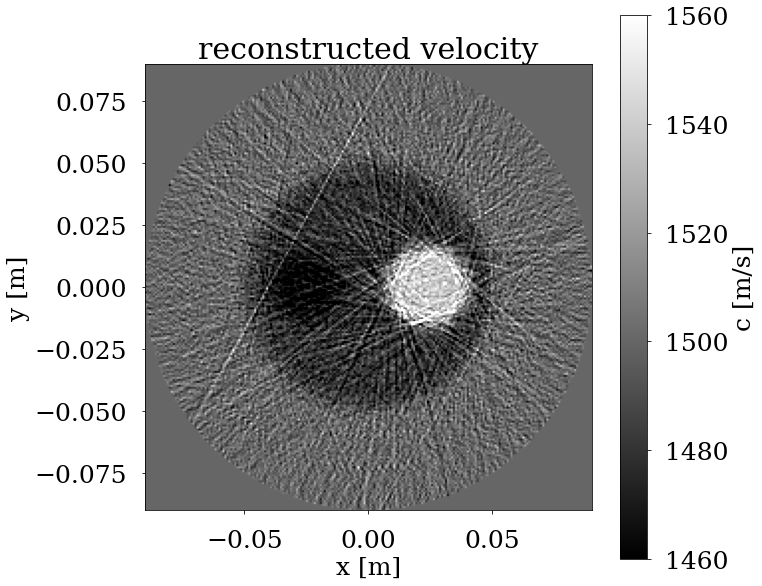

In [21]:
imsparse_re = 1 / (m_prior - np.real(imsparse))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(
    np.reshape(imsparse_re, [g.x.shape[0], g.y.shape[0]]).T,
    extent=[
        g.x[0],
        g.x[0] + g.x.shape[0] * g.spacing,
        g.y[0],
        g.y[0] + g.y.shape[0] * g.spacing,
    ],
    cmap="gray",
    vmin=1460,
    vmax=1560,
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar(label="c [m/s]")
plt.title("reconstructed velocity")